In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from bandits import *
from client import *
from server import *
from bandits_improved import *
from client_improved import *
from server_improved import *

Performance

In [3]:
T = 10000
K = 9
M = 4
alpha_list = np.array([0, 0.5, 0.9, 1])
#means = np.random.random((M, K))


means = np.array([[1 , 0, 0, 0, 0.9, 0.4, 0.35, 0.35, 0.5],
                  [0, 1, 0, 0, 0.3, 0.9, 0.35, 0.3, 0.5],
                  [0, 0, 1, 0, 0.35, 0.35, 0.9, 0.3, 0.5],
                  [0, 0, 0, 1, 0.4, 0.3, 0.35, 0.9, 0.5]])

n_simu = 10

print(means)

[[1.   0.   0.   0.   0.9  0.4  0.35 0.35 0.5 ]
 [0.   1.   0.   0.   0.3  0.9  0.35 0.3  0.5 ]
 [0.   0.   1.   0.   0.35 0.35 0.9  0.3  0.5 ]
 [0.   0.   0.   1.   0.4  0.3  0.35 0.9  0.5 ]]


In [4]:
def fp(p):
    return 2**p*np.log(T)

In [5]:
# try to load for a warm restart
try:
    regret_reward = np.load('scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [6]:
regret_reward.keys()

dict_keys(['0.0', '0.2', '0.5', '0.9', '1.0'])

In [15]:
regret_reward = {}
raw_regret = {}
local_reward = {}
global_reward = {}
mixed_reward = {}

In [16]:
pfed = None

In [17]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    # np.save('scores/raw_regret.npy', raw_regret)
    # np.save('scores/local_reward.npy',local_reward)
    # np.save('scores/global_reward.npy',global_reward)
    # np.save('scores/mixed_reward.npy',mixed_reward)
    # np.save('scores/regret_reward.npy', regret_reward)
    # del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    # np.save('scores/raw_regret.npy', raw_regret)
    # np.save('scores/local_reward.npy',local_reward)
    # np.save('scores/global_reward.npy',global_reward)
    # np.save('scores/mixed_reward.npy',mixed_reward)
    # np.save('scores/regret_reward.npy', regret_reward)
    # del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:1.0: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


In [18]:
len(raw_regret[str(round(alpha_list[0],2))][0])

10000

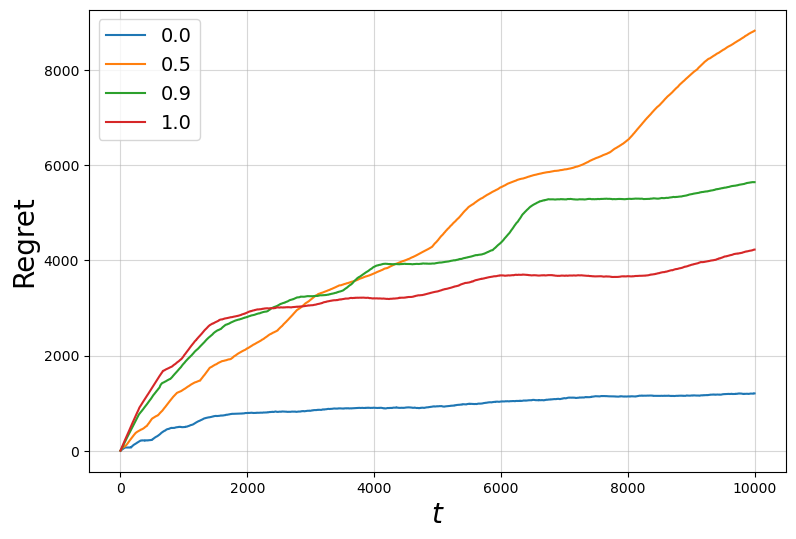

In [19]:
# try:
#     regret_reward = np.load('scores/regret_reward.npy',allow_pickle=True).item()
# except FileNotFoundError:
#     regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

New clients on old method

In [37]:
n_simu = 10

means_new = np.array(
    [[1.05, 0, 0, 0, 0.9, 0.45, 0.3, 0.35, 0.5],
    [0, 1, 0.02, 0, 0.35, 0.9, 0.35, 0.3, 0.5],
    [0, 0, 1, 0.01, 0.3, 0.35, 0.89, 0.3, 0.5],
    [0, 0, 0, 1, 0.4, 0.3, 0.35, 0.9, 0.5]]
)

In [38]:
regret_reward = {}

In [ ]:
len(raw_regret[str(round(alpha_list[0],2))][0])

In [39]:
# for alpha in alpha_list:
#     raw_regret[str(round(alpha,2))] = []
#     local_reward[str(round(alpha,2))] = []
#     global_reward[str(round(alpha,2))] = []
#     mixed_reward[str(round(alpha,2))] = []

In [40]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu#-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            # pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            pfed.update_means(means_new)
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    # np.save('scores/raw_regret.npy', raw_regret)
    # np.save('scores/local_reward.npy',local_reward)
    # np.save('scores/global_reward.npy',global_reward)
    # np.save('scores/mixed_reward.npy',mixed_reward)
    # np.save('scores/regret_reward.npy', regret_reward)
    # del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    # np.save('scores/raw_regret.npy', raw_regret)
    # np.save('scores/local_reward.npy',local_reward)
    # np.save('scores/global_reward.npy',global_reward)
    # np.save('scores/mixed_reward.npy',mixed_reward)
    # np.save('scores/regret_reward.npy', regret_reward)
    # del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:1.0: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


In [41]:
len(regret_reward[str(round(alpha_list[0],2))][0])

10000

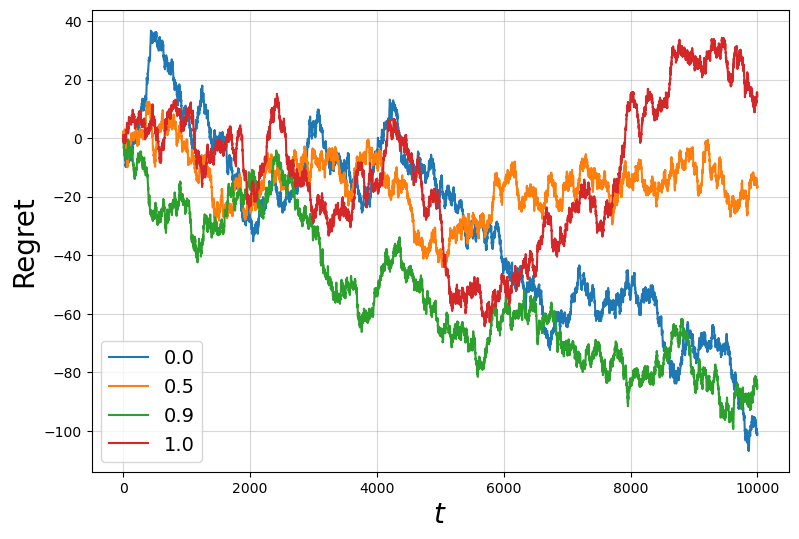

In [42]:
# try:
#     regret_reward = np.load('scores/regret_reward.npy',allow_pickle=True).item()
# except FileNotFoundError:
#     regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

3rd cohort

In [43]:
n_simu = 10

means_new = np.array(
    [[0.95, 0, 0, 0.1, 0.95, 0.45, 0.3, 0.35, 0.5],
    [0.2, 0.9, 0.02, 0, 0.35, 0.92, 0.35, 0.3, 0.5],
    [0, 0, 1.05, 0.01, 0.3, 0.35, 0.85, 0.35, 0.5],
    [0, 0.02, 0, 1.02, 0.42, 0.3, 0.35, 0.9, 0.51]]
)

In [44]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu#-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            # pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            pfed.update_means(means_new)
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1

    # also saves the scores if we ran the whole algorithm without interrupting
    # np.save('scores/raw_regret.npy', raw_regret)
    # np.save('scores/local_reward.npy',local_reward)
    # np.save('scores/global_reward.npy',global_reward)
    # np.save('scores/mixed_reward.npy',mixed_reward)
    # np.save('scores/regret_reward.npy', regret_reward)
    # del raw_regret, local_reward, global_reward, mixed_reward, regret_reward

    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    # np.save('scores/raw_regret.npy', raw_regret)
    # np.save('scores/local_reward.npy',local_reward)
    # np.save('scores/global_reward.npy',global_reward)
    # np.save('scores/mixed_reward.npy',mixed_reward)
    # np.save('scores/regret_reward.npy', regret_reward)
    # del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:1.0: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


In [45]:
len(regret_reward[str(round(alpha_list[0],2))][0])

10000

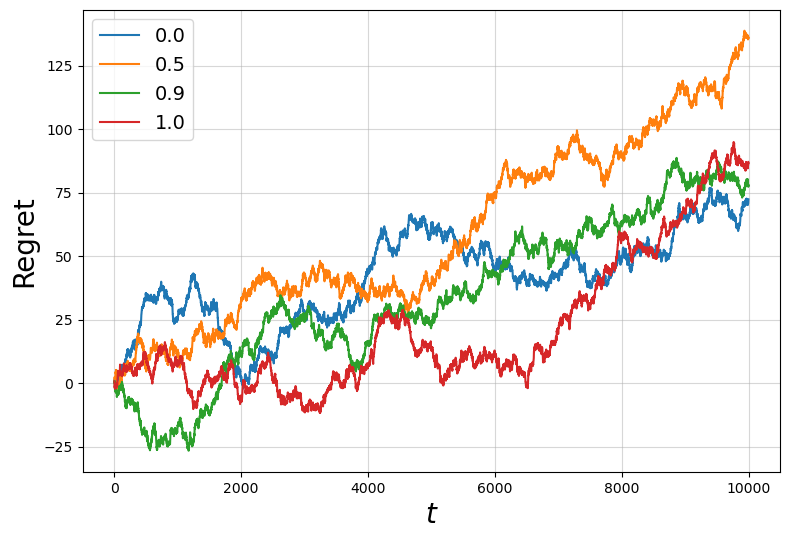

In [46]:
# try:
#     regret_reward = np.load('scores/regret_reward.npy',allow_pickle=True).item()
# except FileNotFoundError:
#     regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)